In [1]:
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt

In [2]:
#originally downloaded here: https://gis-kingcounty.opendata.arcgis.com/datasets/transit-stops-for-king-county-metro-transitstop-point/explore
#my copy available here: https://drive.google.com/file/d/1EyHIIKw29yl3fOt4lM6ft-XtBMkKkzv_/view?usp=sharing
gdf_stops = gpd.read_file("data/transit/metro/Transit_Stops_for_King_County_Metro___transitstop_point.zip")
#made by the metro_data_cleaning.ipynb notebook in this repo
df_ridership = pd.read_parquet("data/cleaned_metro_ridership.parquet")

gdf_merged = gdf_stops.merge(
    df_ridership,
    left_on="STOP_ID",
    right_on="stop_id",
)
size_multipliers = {
    0: 0.01,
    1: 0.5,
    2: 0.75,
    3: 1,
    4: 2,
    5: 2.5,
}
gdf_merged["post_size_category"] = gdf_merged["postpandemic_avg_daily_boardings"].apply(
    lambda b:
    1 if b < 10 else
    2 if b < 25 else
    3 if b < 75 else
    4 if b < 200 else
    5 if pd.notna(b) else
    0
)
gdf_merged["post_size_multiplier"] = gdf_merged["post_size_category"].apply(lambda c: size_multipliers[c])

In [3]:
gdf_less = gdf_merged[[
    "geometry",
    "route_number",
    "stop_id",
    "postpandemic_avg_daily_boardings",
    "prepandemic_avg_daily_boardings",
    "post_size_category",
    "post_size_multiplier",
    "AUTH_NAME"
]].copy()
gdf_less = gdf_less.to_crs("EPSG:3857") # convert to web mercator
gdf_less["geometry"] = gdf_less["geometry"].buffer(100)
gdf_less["post:pre_ridership_ratio"] = (gdf_less["postpandemic_avg_daily_boardings"].fillna(0) + 0.01) / (gdf_less["prepandemic_avg_daily_boardings"].fillna(0) + 0.01)
gdf_less["post:pre_ridership_ratio"] = gdf_less["post:pre_ridership_ratio"].apply(lambda r: r if r < 3 else 3)

In [4]:
gdf_less[gdf_less["route_number"] == 250].drop_duplicates(subset="stop_id").explore(
    column="postpandemic_avg_daily_boardings"
)

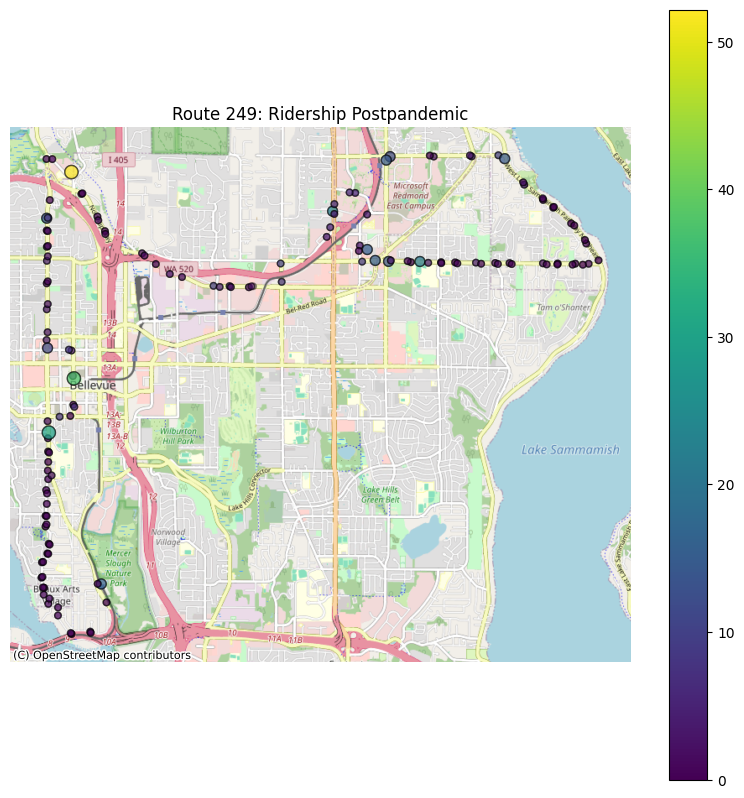

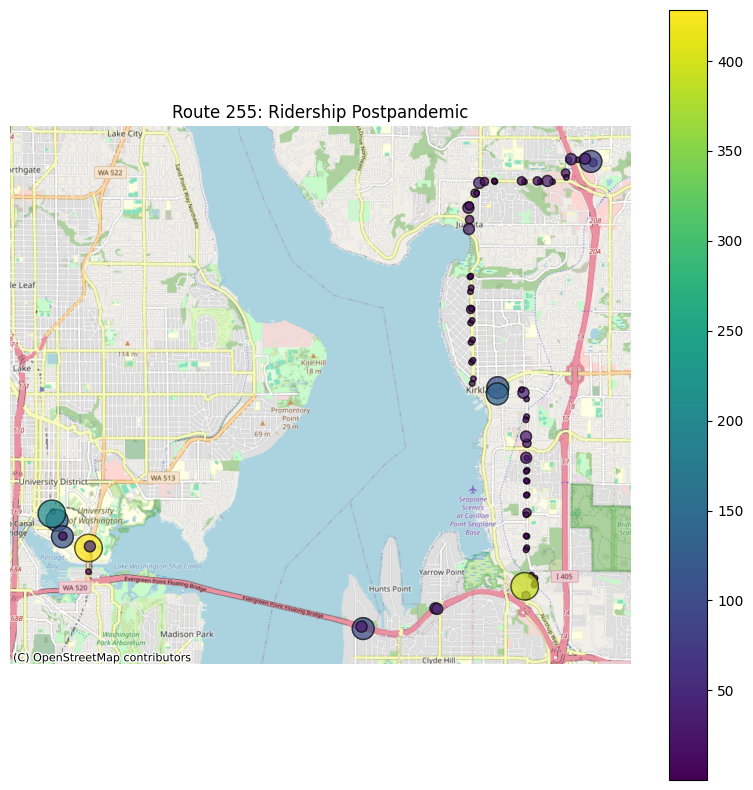

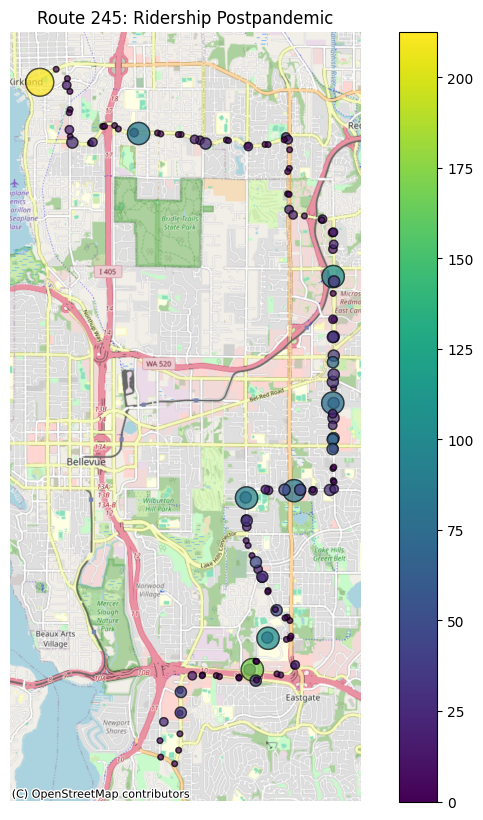

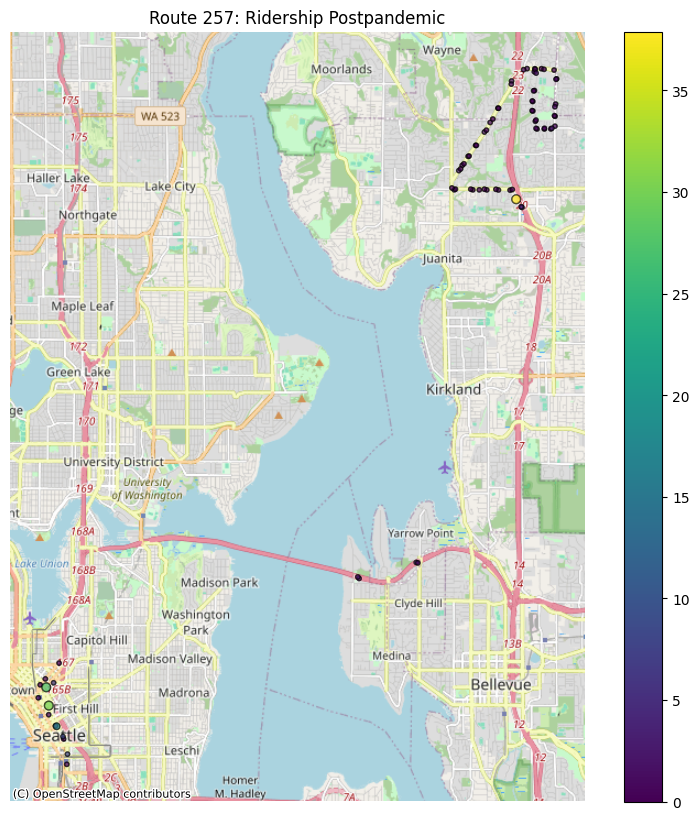

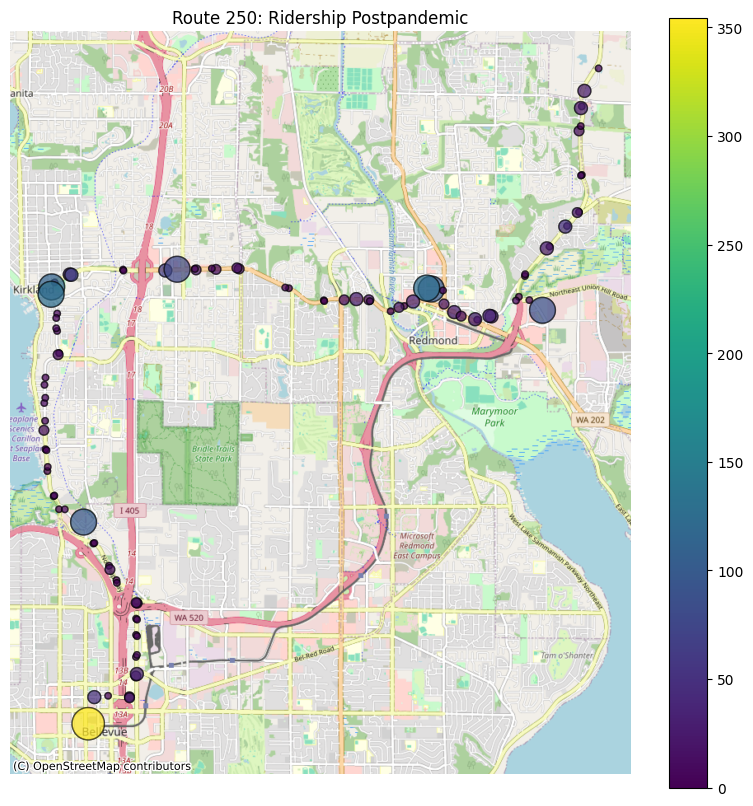

In [5]:
buffer_base = 150
gdf_buffer = gdf_merged[[
    "geometry",
    "route_number",
    "stop_id",
    "postpandemic_avg_daily_boardings",
    "prepandemic_avg_daily_boardings",
    "post_size_multiplier",
    "post_size_category",
    "AUTH_NAME",
]].copy().to_crs("EPSG:3857")
gdf_buffer["geometry"] = gdf_buffer.apply(
    lambda r:
    r["geometry"].buffer(buffer_base * r["post_size_multiplier"]),
    axis=1,
)

for route_number in gdf_buffer[gdf_buffer["postpandemic_avg_daily_boardings"].notna()]["route_number"].unique():
    vmax = None
    if route_number == 255:
        vmax = None
    ax = gdf_buffer[
        (gdf_buffer["route_number"] == route_number)
        & (gdf_buffer["postpandemic_avg_daily_boardings"].notna())
    ].plot(
        column="postpandemic_avg_daily_boardings",
        alpha=0.35,
        figsize=(10,10),
        legend=True,
        vmax=vmax,
        edgecolor="black",
    )
    cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
    ax.axis("off")
    plt.title(f"Route {route_number}: Ridership Postpandemic")

# Kirkland Only Maps

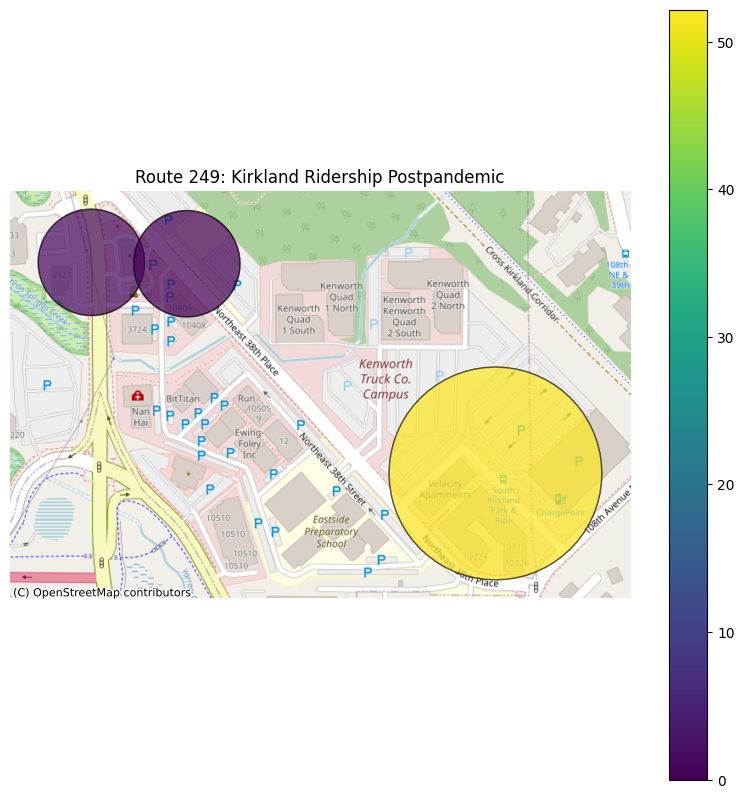

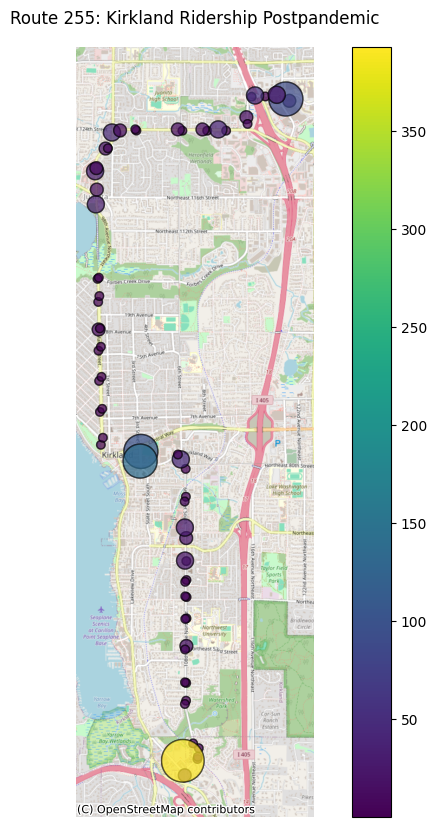

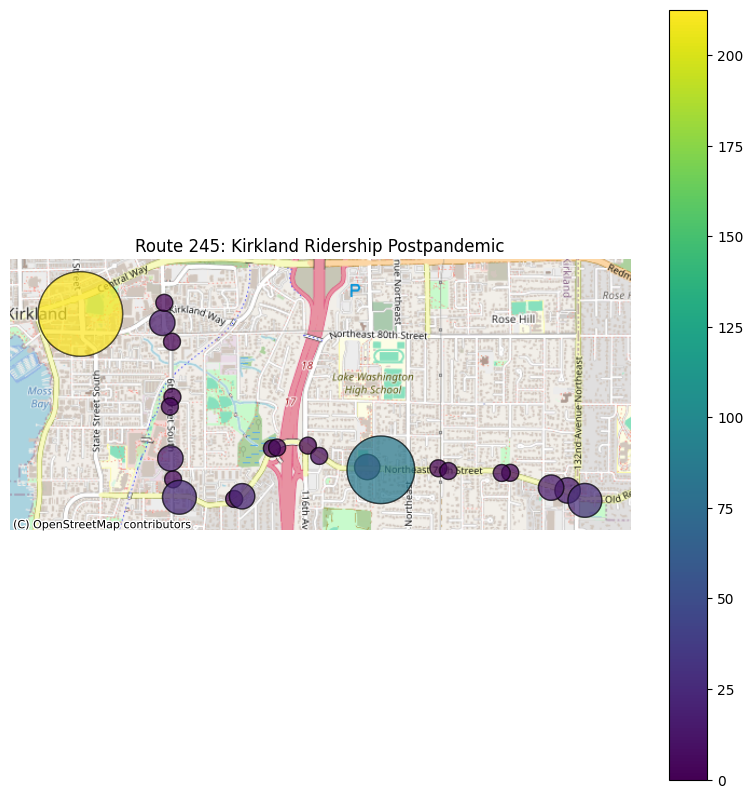

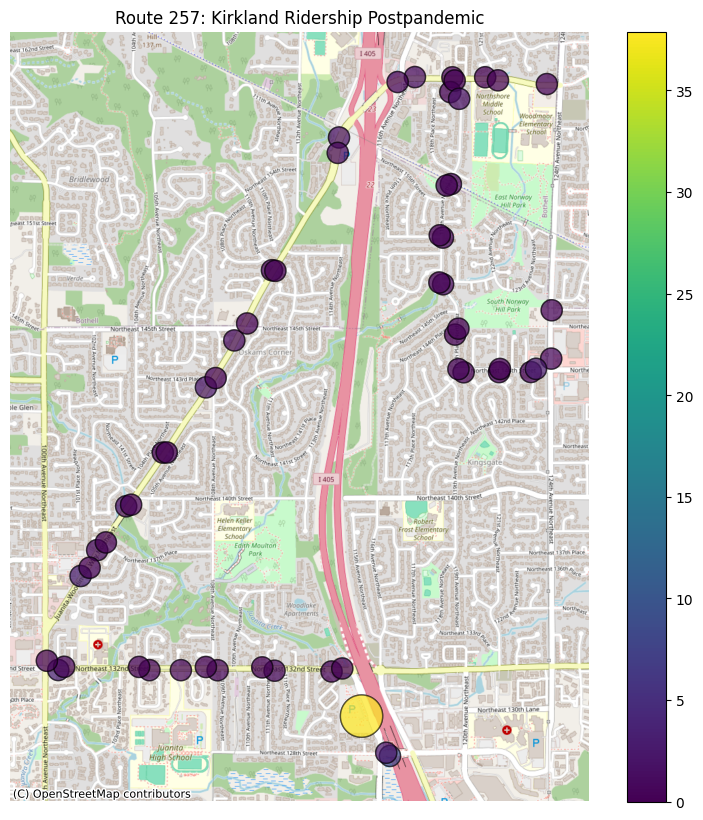

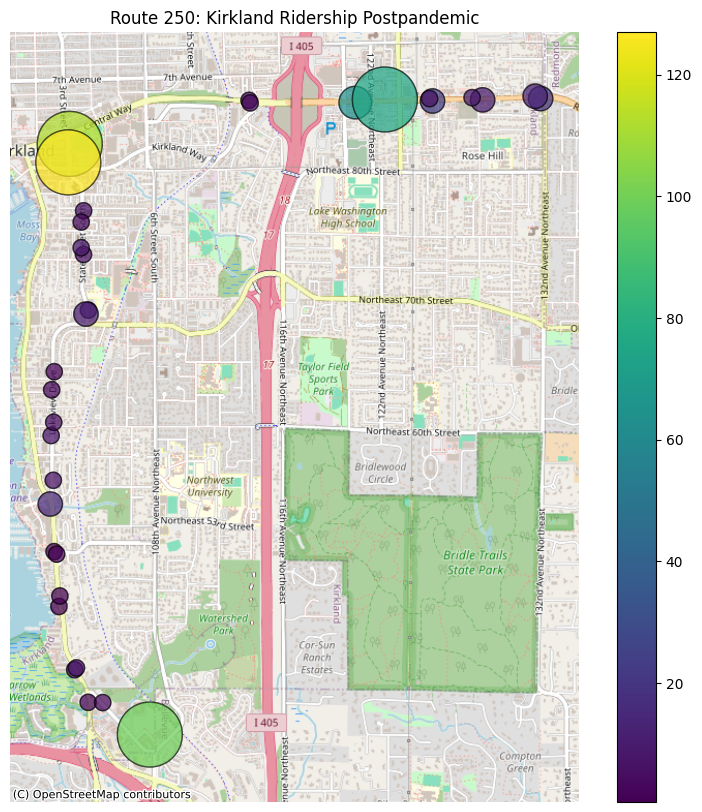

In [6]:
buffer_base = 150
gdf_buffer = gdf_merged[[
    "geometry",
    "route_number",
    "stop_id",
    "postpandemic_avg_daily_boardings",
    "prepandemic_avg_daily_boardings",
    "post_size_multiplier",
    "post_size_category",
    "AUTH_NAME",
]].copy().to_crs("EPSG:3857")
gdf_buffer["geometry"] = gdf_buffer.apply(
    lambda r:
    r["geometry"].buffer(buffer_base * r["post_size_multiplier"]),
    axis=1,
)

for route_number in gdf_buffer[gdf_buffer["postpandemic_avg_daily_boardings"].notna()]["route_number"].unique():
    vmax = None
    if route_number == 255:
        vmax = None
    ax = gdf_buffer[
        (gdf_buffer["route_number"] == route_number)
        & (gdf_buffer["postpandemic_avg_daily_boardings"].notna())
        & (
            (gdf_buffer["AUTH_NAME"] == "Kirkland") |
            (gdf_buffer["AUTH_NAME"] == "King County") |
            (gdf_buffer["stop_id"].isin(
                [
                    74460,
                    74450,
                    85040,
                    74442,
                    74533,
                    74441,
                ]
            ))
        )
        & (~gdf_buffer["stop_id"].isin(
            [
                64835,
                69150,
                69160,
                84015,
                72540,
                72560,
                71830,
            ]
        ))
    ].plot(
        column="postpandemic_avg_daily_boardings",
        alpha=0.35,
        figsize=(10,10),
        legend=True,
        vmax=vmax,
        edgecolor="black",
    )
    cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
    ax.axis("off")
    plt.title(f"Route {route_number}: Kirkland Ridership Postpandemic")

In [7]:
gdf_less.drop(["post:pre_ridership_ratio"], axis=1).to_csv("output/metro_records_request_data.csv", index=None)

In [8]:
gdf_kirkland_stops = []
for route_number in gdf_buffer[gdf_buffer["postpandemic_avg_daily_boardings"].notna()]["route_number"].unique():
    gdf_route = gdf_buffer[
        (gdf_buffer["route_number"] == route_number)
        & (gdf_buffer["postpandemic_avg_daily_boardings"].notna())
        & (
            (gdf_buffer["AUTH_NAME"] == "Kirkland") |
            (gdf_buffer["AUTH_NAME"] == "King County") |
            (gdf_buffer["stop_id"].isin(
                [
                    74460,
                    74450,
                    85040,
                    74442,
                    74533,
                    74441,
                ]
            ))
        )
        & (~gdf_buffer["stop_id"].isin(
            [
                64835,
                69150,
                69160,
                84015,
                72540,
                72560,
                71830,
            ]
        ))
    ].drop_duplicates(subset=["stop_id"]).copy()
    gdf_route["postpandemic_avg_daily_boardings_%"] = gdf_route["postpandemic_avg_daily_boardings"] / gdf_route["postpandemic_avg_daily_boardings"].sum()
    gdf_kirkland_stops.append(gdf_route)
gdf_kirkland_stops = gpd.GeoDataFrame(pd.concat(gdf_kirkland_stops))

In [9]:
gdf_kirkland_stops[gdf_kirkland_stops["route_number"] == 250].sort_values("postpandemic_avg_daily_boardings_%", ascending=False).head(4).explore()

In [10]:
gdf_kirkland_stops[gdf_kirkland_stops["route_number"] == 245].sort_values("postpandemic_avg_daily_boardings_%", ascending=False)[["postpandemic_avg_daily_boardings_%", "stop_id", "geometry"]]

postpandemic_avg_daily_boardings_%  stop_id  \
2215                            0.439554    73818   
1950                            0.176896    72310   
1981                            0.053317    72371   
1464                            0.053110    70681   
2097                            0.045464    72290   
1458                            0.035958    70679   
834                             0.031205    72060   
957                             0.030791    72120   
1446                            0.030585    70676   
1977                            0.029552    72360   
1956                            0.012606    72312   
1971                            0.010333    72348   
1452                            0.010126    70677   
1965                            0.009713    72330   
2100                            0.008266    72294   
978                             0.006406    72161   
840                             0.004960    72080   
951                             0.004133    72100   
963                             0.003100    72140   
960                             0.002480    72134   
984                             0.000620    72163   
1953                            0.000620    72311   
2695                            0.000207    74575   
990                             0.000000    72164   

                                               geometry  
2215  POLYGON ((-13603261.273 6053206.283, -13603263...  
1950  POLYGON ((-13600669.194 6051822.846, -13600670...  
1981  POLYGON ((-13599007.508 6051551.457, -13599008...  
1464  POLYGON ((-13602607.894 6051578.744, -13602608...  
2097  POLYGON ((-13602088.421 6051588.073, -13602088...  
1458  POLYGON ((-13602725.151 6051924.423, -13602725...  
834   POLYGON ((-13599198.798 6051639.345, -13599199...  
957   POLYGON ((-13600977.775 6051847.598, -13600978...  
1446  POLYGON ((-13602797.020 6053127.753, -13602797...  
1977  POLYGON ((-13599345.182 6051664.542, -13599345...  
1956  POLYGON ((-13601441.299 6051945.849, -13601441...  
1971  POLYGON ((-13599820.976 6051794.566, -13599821...  
1452  POLYGON ((-13602766.704 6052384.189, -13602767...  
1965  POLYGON ((-13600294.380 6051812.003, -13600294...  
2100  POLYGON ((-13601814.950 6052020.392, -13601815...  
978   POLYGON ((-13602738.582 6051738.519, -13602738...  
840   POLYGON ((-13599745.543 6051796.197, -13599745...  
951   POLYGON ((-13600383.824 6051836.547, -13600384...  
963   POLYGON ((-13602196.440 6051564.027, -13602196...  
960   POLYGON ((-13601861.351 6052012.230, -13601861...  
984   POLYGON ((-13602744.702 6052468.981, -13602745...  
1953  POLYGON ((-13601541.412 6052037.456, -13601541...  
2695  POLYGON ((-13602816.421 6053305.595, -13602816...  
990   POLYGON ((-13602748.394 6052959.608, -13602748...

In [11]:
gdf_kirkland_stops[gdf_kirkland_stops["route_number"] == 255].sort_values("postpandemic_avg_daily_boardings_%", ascending=False)[["postpandemic_avg_daily_boardings_%", "stop_id", "geometry"]]

postpandemic_avg_daily_boardings_%  stop_id  \
2984                            0.280183    74450   
2209                            0.098125    73816   
2199                            0.071383    73814   
2159                            0.064466    74232   
2309                            0.042573    74734   
...                                  ...      ...   
991                             0.000357    72164   
309                             0.000285    70460   
2147                            0.000214    74226   
2811                            0.000071    74530   
530                             0.000071    70510   

                                               geometry  
2984  POLYGON ((-13602498.826 6047808.168, -13602500...  
2209  POLYGON ((-13603327.562 6053097.460, -13603329...  
2199  POLYGON ((-13603314.323 6053268.191, -13603315...  
2159  POLYGON ((-13600754.574 6059488.931, -13600756...  
2309  POLYGON ((-13601449.300 6059551.570, -13601450...  
...                                                 ...  
991   POLYGON ((-13602748.394 6052959.608, -13602748...  
309   POLYGON ((-13604233.935 6054584.784, -13604234...  
2147  POLYGON ((-13601342.627 6059533.766, -13601342...  
2811  POLYGON ((-13602740.767 6048868.559, -13602741...  
530   POLYGON ((-13604281.426 6056335.212, -13604281...  

[67 rows x 3 columns]

In [12]:
route_num = 255
print(gdf_kirkland_stops[gdf_kirkland_stops["route_number"] == route_num].shape)
gdf_kirkland_stops[gdf_kirkland_stops["route_number"] == route_num].sort_values("postpandemic_avg_daily_boardings_%", ascending=False)["postpandemic_avg_daily_boardings_%"].cumsum().head(10)

(67, 9)


2984    0.280183
2209    0.378307
2199    0.449690
2159    0.514155
2309    0.556728
1447    0.589674
158     0.621978
2760    0.649718
179     0.675176
245     0.700349
Name: postpandemic_avg_daily_boardings_%, dtype: float64

In [13]:
route_num = 245
print(gdf_kirkland_stops[gdf_kirkland_stops["route_number"] == route_num].shape)
gdf_kirkland_stops[gdf_kirkland_stops["route_number"] == route_num].sort_values("postpandemic_avg_daily_boardings_%", ascending=False)["postpandemic_avg_daily_boardings_%"].cumsum().head(10)

(24, 9)


2215    0.439554
1950    0.616450
1981    0.669766
1464    0.722877
2097    0.768341
1458    0.804298
834     0.835503
957     0.866295
1446    0.896880
1977    0.926431
Name: postpandemic_avg_daily_boardings_%, dtype: float64

In [14]:
route_num = 250
print(gdf_kirkland_stops[gdf_kirkland_stops["route_number"] == route_num].shape)
gdf_kirkland_stops[gdf_kirkland_stops["route_number"] == route_num].sort_values("postpandemic_avg_daily_boardings_%", ascending=False)["postpandemic_avg_daily_boardings_%"].cumsum().head(10)

(33, 9)


2208    0.189552
2198    0.356567
2983    0.504627
2857    0.617910
2356    0.712388
2361    0.747313
2406    0.776567
681     0.798806
2847    0.819254
2364    0.835224
Name: postpandemic_avg_daily_boardings_%, dtype: float64